In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

origin_file = "../data/immoweb-dataset.csv"
cleaned_file = "../data/cleaned_data.csv"
cleaned_file_modified = "../data/cleaned_data_modified.csv"
df = pd.read_csv(origin_file)
df_cleaned = pd.read_csv(cleaned_file_modified)

            type    subtype bedroomCount  bathroomCount province   locality  \
37078  APARTMENT  APARTMENT         97.0           71.0  Hainaut  Charleroi   

       habitableSurface  hasBasement buildingCondition  \
37078            2800.0         True            AS_NEW   

      buildingConstructionYear  ...  parkingCountIndoor  parkingCountOutdoor  \
37078                   2004.0  ...                 0.0                  0.0   

      toiletCount  hasSwimmingPool terraceSurface  epcScore      price  \
37078         0.0            False     No terrace         B  6200000.0   

       kitchen_installed    region price_per_m2  
37078               True  Wallonia  2214.285714  

[1 rows x 25 columns]
           price  bathroomCount  habitableSurface         province
472    1800000.0           22.0             800.0         Brussels
533     995000.0           15.0             380.0         Brussels
542     995000.0           15.0             380.0         Brussels
708    1100000.0       

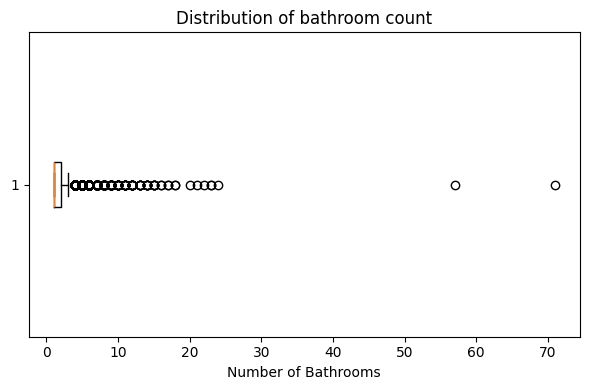

In [167]:

max_bathroom = df_cleaned['bathroomCount'].max()
print(df_cleaned[df_cleaned['bathroomCount'] == max_bathroom])
print(df_cleaned[df_cleaned['bathroomCount'] > 10][['price', 'bathroomCount', 'habitableSurface', 'province']])

plt.figure(figsize=(6, 4))
plt.boxplot(df_cleaned['bathroomCount'].dropna(), vert=False)

plt.xlabel('Number of Bathrooms')
plt.title('Distribution of bathroom count')
plt.tight_layout()
plt.show()

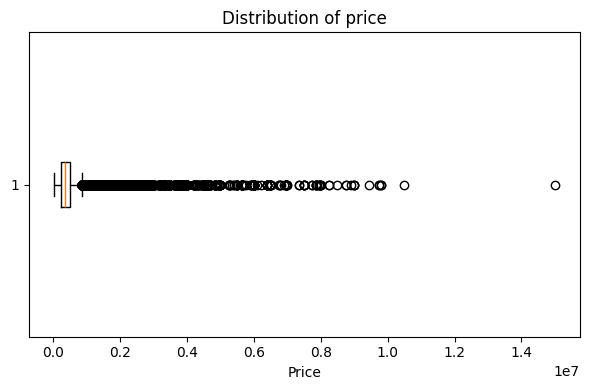

In [5]:
max_bathroom = df_cleaned['price'].max()

plt.figure(figsize=(6, 4))
plt.boxplot(df_cleaned['price'].dropna(), vert=False)

plt.xlabel('Price')
plt.title('Distribution of price')
plt.tight_layout()
plt.show()

bathroomCount          0.548259
habitableSurface       0.080328
facedeCount            0.125984
landSurface            0.200041
parkingCountIndoor    -0.000549
parkingCountOutdoor    0.132658
toiletCount            0.065972
Name: price, dtype: float64


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/600150459.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")


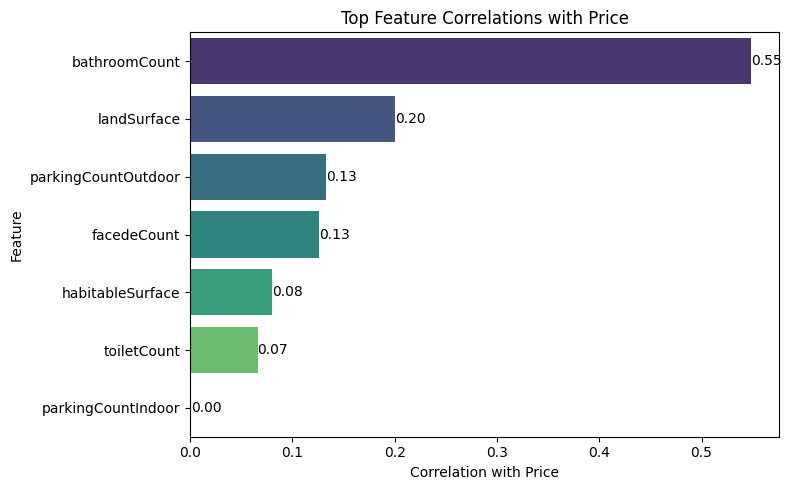

In [168]:

df_cleaned = df_cleaned[df_cleaned['bathroomCount'] <= 10]
df_encoded = pd.get_dummies(df_cleaned)
df_encoded = df_encoded.select_dtypes(include='number')
corr_matrix = df_encoded.corr()
price_corr = corr_matrix['price'].drop(['price', 'price_per_m2'], errors='ignore')

print(price_corr)
top_corr = price_corr.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
for i, value in enumerate(top_corr.values):
    ax.text(
        x=value,  
        y=i,
        s=f"{float(value):.2f}",  
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

plt.xlabel("Correlation with Price")
plt.ylabel("Feature")
plt.title("Top Feature Correlations with Price")
plt.tight_layout()
plt.show()

In [169]:

least_influential = price_corr.abs().sort_values(ascending=True)
least_influential_signed = price_corr.loc[least_influential.index]
print(least_influential_signed.head(10))

parkingCountIndoor    -0.000549
toiletCount            0.065972
habitableSurface       0.080328
facedeCount            0.125984
parkingCountOutdoor    0.132658
landSurface            0.200041
bathroomCount          0.548259
Name: price, dtype: float64


In [170]:
# Filter Flanders data
flanders_df = df_cleaned[df_cleaned['region'] == 'Flanders']
g_score = flanders_df['epcScore'].str.startswith('G', na=False)
print(f"Number of EPC scores starting with 'G' in Flanders: {g_score.sum()}")

df_cleaned.loc[
    (df_cleaned['region'] == 'Flanders') & 
    (df_cleaned['epcScore'].str.startswith('G', na=False)), 
    'epcScore'
] = 'unknown'

Number of EPC scores starting with 'G' in Flanders: 6


epcScore_norm
A    3853.157661
B    3812.965281
C    3012.214841
D    2500.715892
E    2298.179669
F    2064.986451
G    2287.389939
Name: price_per_m2, dtype: float64


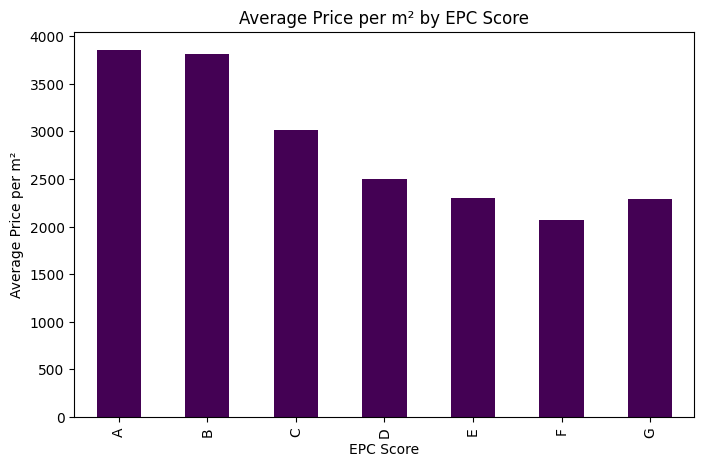

In [171]:
# print(df_cleaned['epcScore'].value_counts())
def normalize_epc(epc):
    if epc in ['A+', 'A++']:
        return 'A'
    return epc

df_cleaned['epcScore_norm'] = df_cleaned['epcScore'].apply(normalize_epc)
exclude_epc = ['G_C', 'C_A', 'F_C', 'F_D', 'E_D', 'D_C', 'C_B', 'unknown']
df_valid_epc = df_cleaned[~df_cleaned['epcScore_norm'].isin(exclude_epc)]
epc_price_per_m2 = df_valid_epc.groupby('epcScore_norm')['price_per_m2'].mean().sort_index()
print(epc_price_per_m2)

epc_price_per_m2.plot(kind='bar', figsize=(8,5), title='Average Price per m² by EPC Score', colormap='viridis')
plt.ylabel('Average Price per m²')
plt.xlabel('EPC Score')
plt.show()


epcScore_norm            A            B            C            D  \
region                                                              
Brussels       4743.902439  4225.000000  3776.978417  3486.744495   
Flanders       3319.327731  3048.543689  2685.497998  2193.513514   
Wallonia       2658.917669  2398.373984  1969.100453  1750.000000   

epcScore_norm            E            F            G  
region                                                
Brussels       3286.527887  3144.736842  3055.555556  
Flanders       1963.486985  1752.941176          NaN  
Wallonia       1544.310132  1416.994751  1460.784314  


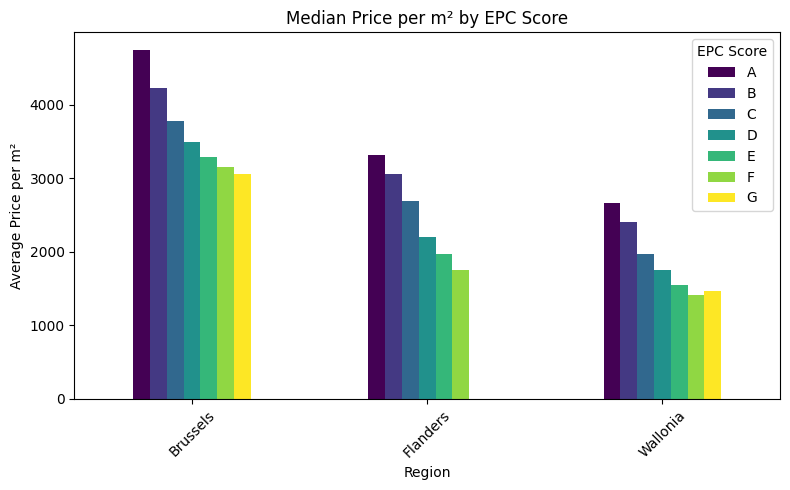

In [172]:
epc_price_per_m2 = df_valid_epc.groupby(['region', 'epcScore_norm'])['price_per_m2'].median().unstack()
print(epc_price_per_m2)

epc_price_per_m2.plot(kind='bar', figsize=(8,5), title='Median Price per m² by EPC Score' , colormap='viridis')
plt.ylabel('Average Price per m²')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='EPC Score')
plt.tight_layout()
plt.show()

In [173]:
df_wallonia = df_cleaned[df_cleaned['region'] == 'Wallonia']
print(df_wallonia['epcScore'].value_counts())

df_wallonia.groupby('epcScore')['price_per_m2'].agg(['mean', 'median', 'count'])
df_wallonia.groupby('epcScore')['habitableSurface'].median()


epcScore
C          2684
D          2584
B          2449
E          1756
G          1583
F          1460
A          1233
unknown     550
A+          530
A++          99
C_A           2
F_C           2
G_C           2
F_D           2
E_D           2
D_C           1
C_B           1
Name: count, dtype: int64


epcScore
A          125.0
A+         158.0
A++        180.0
B          137.0
C          160.0
C_A        570.0
C_B        313.0
D          160.0
D_C        220.0
E          154.0
E_D        197.0
F          150.0
F_C        385.0
F_D        419.0
G          133.0
G_C        320.0
unknown    145.0
Name: habitableSurface, dtype: float64

In [174]:
# Normalize EPC
def normalize_epc(epc):
    if epc in ['A+', 'A++']:
        return 'A'
    return epc

df_cleaned['epcScore_norm'] = df_cleaned['epcScore'].apply(normalize_epc)

# Exclude noisy EPC values
exclude_epc = ['G_C', 'C_A', 'F_C', 'F_D', 'E_D', 'D_C', 'C_B', 'unknown']
filtered_df = df_cleaned[~df_cleaned['epcScore'].isin(exclude_epc)]

# Filter Wallonia
df_wallonia = filtered_df[filtered_df['region'] == 'Wallonia']

# Group by normalized EPC score and get median habitable surface
surface_by_epc = df_wallonia.groupby('epcScore_norm')['habitableSurface'].median().sort_index()

print(surface_by_epc)


epcScore_norm
A    143.0
B    137.0
C    160.0
D    160.0
E    154.0
F    150.0
G    133.0
Name: habitableSurface, dtype: float64


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/22414651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=surface_by_epc.index, y=surface_by_epc.values, palette="viridis")


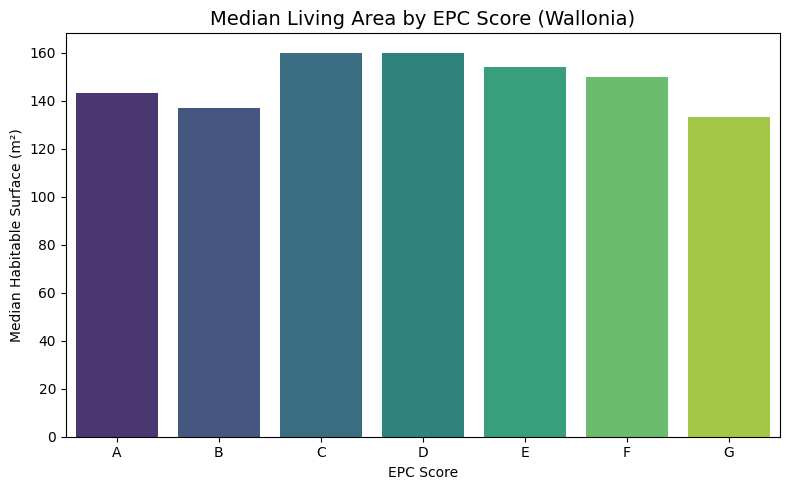

In [175]:
plt.figure(figsize=(8, 5))
sns.barplot(x=surface_by_epc.index, y=surface_by_epc.values, palette="viridis")

plt.title('Median Living Area by EPC Score (Wallonia)', fontsize=14)
plt.xlabel('EPC Score')
plt.ylabel('Median Habitable Surface (m²)')
plt.tight_layout()
plt.show()

/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/2409872252.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_plot, x='buildingConstructionYear', y='habitableSurface', alpha=0.3, s=10, palette="viridis")


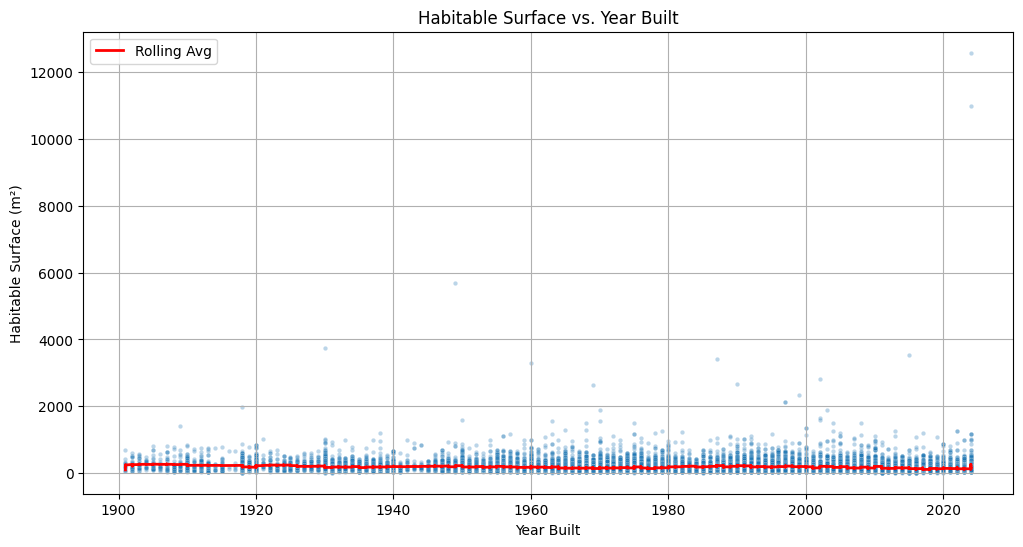

In [176]:
# Convert to numeric (fix strings)
df_cleaned['buildingConstructionYear'] = pd.to_numeric(df_cleaned['buildingConstructionYear'], errors='coerce')

# Filter valid years
df_plot = df_cleaned[(df_cleaned['buildingConstructionYear'] > 1900) & (df_cleaned['buildingConstructionYear'] < 2025)]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot, x='buildingConstructionYear', y='habitableSurface', alpha=0.3, s=10, palette="viridis")

# Sort and calculate average
df_plot_sorted = df_plot.sort_values('buildingConstructionYear').copy()
# rolling average
df_plot_sorted['rolling_avg'] = df_plot_sorted['habitableSurface'].rolling(window=200, min_periods=1).mean()
#  plot the trend line
plt.plot(df_plot_sorted['buildingConstructionYear'], df_plot_sorted['rolling_avg'], color='red', linewidth=2, label='Rolling Avg')

plt.title('Habitable Surface vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Habitable Surface (m²)')
plt.legend()
plt.grid(True)
plt.show()



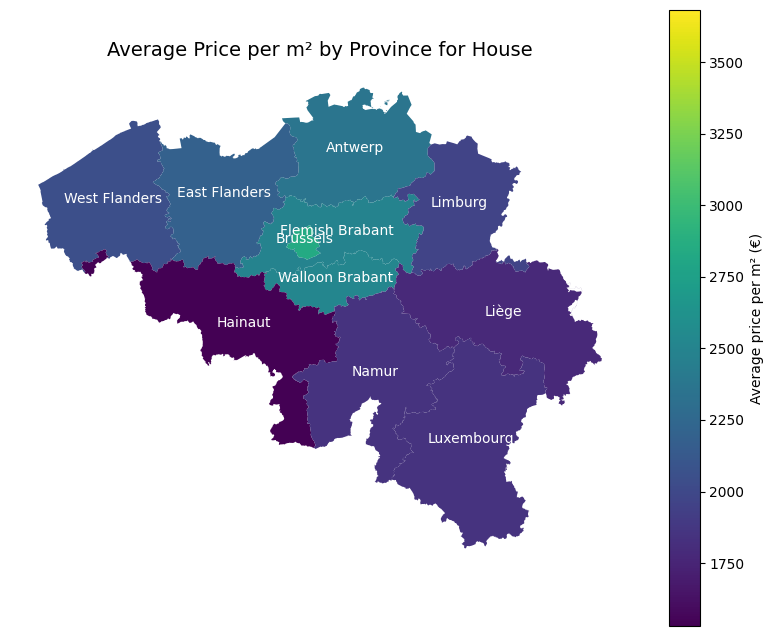

In [ ]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

def filter_outliers(df, column='price_per_m2'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filtered_df = df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]
    return filtered_df

houses_df = df_cleaned[df_cleaned['type'] == 'HOUSE']
apt_df = df_cleaned[df_cleaned['type'] == 'APARTMENT']

houses_filtered = filter_outliers(houses_df)
apt_filtered = filter_outliers(apt_df)

avg_apt = apt_filtered.groupby("province")["price_per_m2"].mean().reset_index()
avg_house = houses_filtered.groupby("province")["price_per_m2"].mean().reset_index()

# set same scale
vmin = min(avg_apt['price_per_m2'].min(), avg_house['price_per_m2'].min())
vmax = max(avg_apt['price_per_m2'].max(), avg_house['price_per_m2'].max())

gdf = gpd.read_file("../map/BELGIUM_provinces.shp")
# print(gdf.head())
dutch_to_english = {
    'Antwerpen': 'Antwerp',
    'Brussel': 'Brussels',
    'Oost-Vlaanderen': 'East Flanders',
    'Vlaams Brabant': 'Flemish Brabant',
    'Henegouwen': 'Hainaut',
    'Limburg': 'Limburg',
    'Luik': 'Liège',
    'Luxemburg': 'Luxembourg',
    'Namen': 'Namur',
    'Waals Brabant': 'Walloon Brabant',
    'West-Vlaanderen': 'West Flanders'
}
# new col with eng name for province
gdf['ENG_Name'] = gdf['NE_Name'].map(dutch_to_english)

avg_house["ENG_Name"] = avg_house["province"]
merged = gdf.merge(avg_house, on="ENG_Name")

fig, ax = plt.subplots(1, figsize=(10, 8))
merged.plot(column="price_per_m2",  cmap="viridis", legend=True, ax=ax,legend_kwds={'label': "Average price per m² (€)", 'orientation': "vertical"}, vmin=vmin, vmax=vmax)

merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=(x.geometry.centroid.x, x.geometry.centroid.y + 0.09), ha='center', color = "white", fontsize=10), axis=1)


ax.set_title("Average Price per m² by Province for House", fontsize=14)
ax.axis("off")
plt.show()

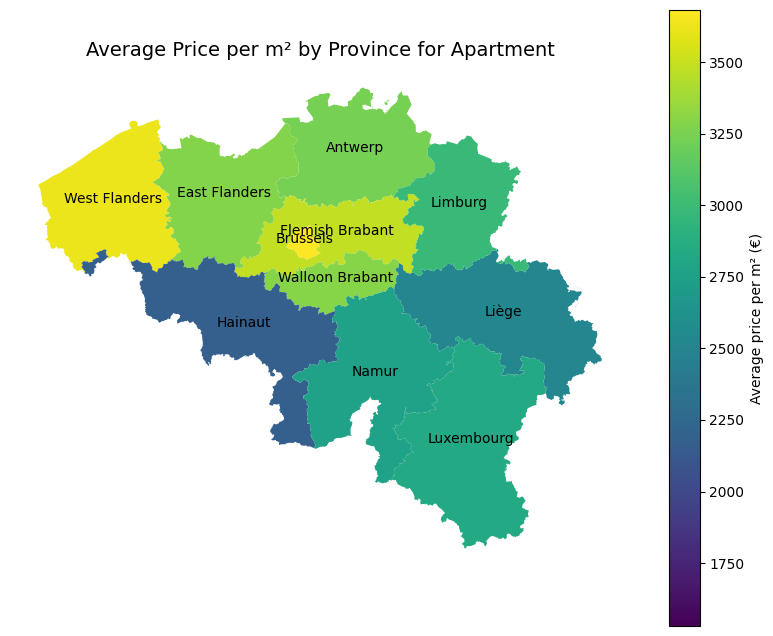

In [20]:

avg_apt["ENG_Name"] = avg_apt["province"]
merged = gdf.merge(avg_apt, on="ENG_Name")

fig, ax = plt.subplots(1,figsize=(10, 8))
merged.plot(column="price_per_m2",  cmap="viridis",legend_kwds={'label': "Average price per m² (€)", 'orientation': "vertical"}, legend=True, ax=ax, vmin=vmin, vmax=vmax)
merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=x.geometry.centroid.coords[0], ha='center', color = "black"), axis=1)

# for idx, row in merged.iterrows():
#     # Get the centroid of the polygon for label placement
#     centroid = row['geometry'].centroid
#     ax.text(s=row['ENG_Name'], x=centroid.x, y=centroid.y,
#             horizontalalignment='center', fontsize=9, fontweight='bold', color='white')

ax.set_title("Average Price per m² by Province for Apartment", fontsize=14)
ax.axis("off")
plt.show()

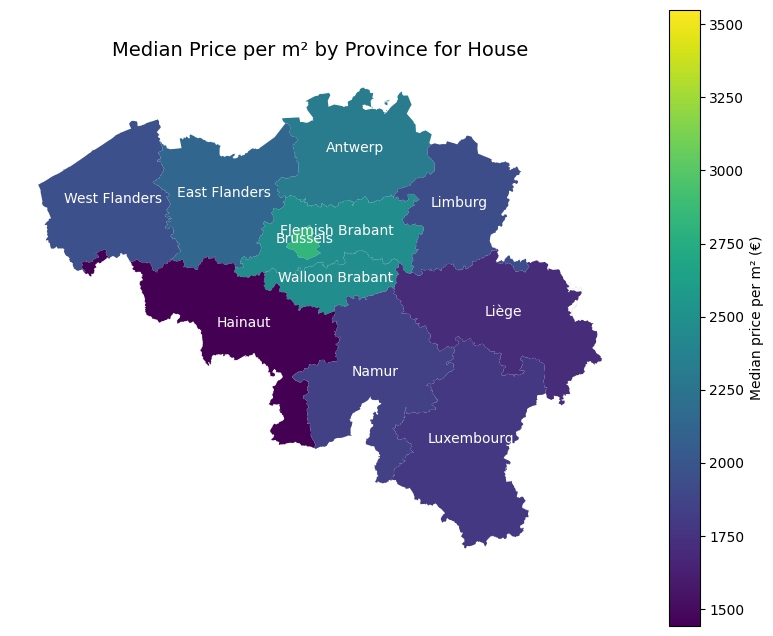

In [23]:
median_apt = apt_filtered.groupby("province")["price_per_m2"].median().reset_index()
median_house = houses_filtered.groupby("province")["price_per_m2"].median().reset_index()

# set same scale
vmin = min(median_apt['price_per_m2'].min(), median_house['price_per_m2'].min())
vmax = max(median_apt['price_per_m2'].max(), median_house['price_per_m2'].max())

gdf = gpd.read_file("../map/BELGIUM_provinces.shp")

dutch_to_english = {
    'Antwerpen': 'Antwerp',
    'Brussel': 'Brussels',
    'Oost-Vlaanderen': 'East Flanders',
    'Vlaams Brabant': 'Flemish Brabant',
    'Henegouwen': 'Hainaut',
    'Limburg': 'Limburg',
    'Luik': 'Liège',
    'Luxemburg': 'Luxembourg',
    'Namen': 'Namur',
    'Waals Brabant': 'Walloon Brabant',
    'West-Vlaanderen': 'West Flanders'
}
# new col with eng name for province
gdf['ENG_Name'] = gdf['NE_Name'].map(dutch_to_english)


median_house["ENG_Name"] = median_house["province"]
merged = gdf.merge(median_house, on="ENG_Name")

fig, ax = plt.subplots(figsize=(10, 8))

merged.plot(column="price_per_m2",  cmap="viridis", legend=True,legend_kwds={'label': "Median price per m² (€)", 'orientation': "vertical"}, ax=ax, vmin=vmin, vmax=vmax)
merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=x.geometry.centroid.coords[0], ha='center', color = "white"), axis=1)
# for idx, row in merged.iterrows():
#     centroid = row['geometry'].centroid
#     ax.text(s=row['ENG_Name'], x=centroid.x, y=centroid.y,
#             horizontalalignment='center', fontsize=9, fontweight='bold', color='white')

ax.set_title("Median Price per m² by Province for House", fontsize=14)
ax.axis("off")
plt.show()

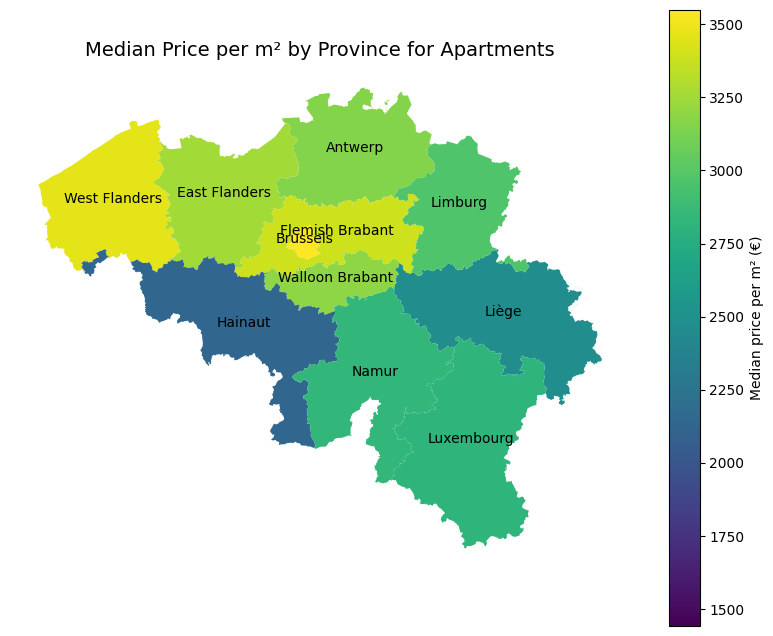

In [24]:
median_apt["ENG_Name"] = median_apt["province"]
merged = gdf.merge(median_apt, on="ENG_Name")

fig, ax = plt.subplots(1,figsize=(10, 8))

merged.plot(column="price_per_m2",  cmap="viridis", legend=True, legend_kwds={'label': "Median price per m² (€)", 'orientation': "vertical"},ax=ax, vmin=vmin, vmax=vmax)
merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=x.geometry.centroid.coords[0], ha='center', color = "black"), axis=1)

ax.set_title("Median Price per m² by Province for Apartments", fontsize=14)
ax.axis("off")
plt.show()

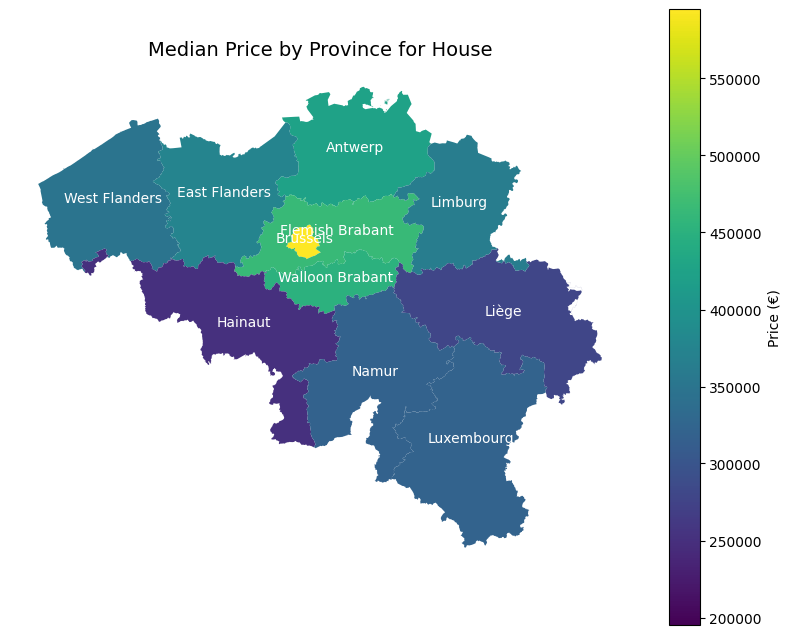

In [27]:
def filter_outliers(df, column='price'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filtered_df = df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]
    return filtered_df

houses_df = df_cleaned[df_cleaned['type'] == 'HOUSE']
apt_df = df_cleaned[df_cleaned['type'] == 'APARTMENT']

houses_filtered = filter_outliers(houses_df)
apt_filtered = filter_outliers(apt_df)


median_apt = apt_filtered.groupby("province")["price"].median().reset_index()
median_house = houses_filtered.groupby("province")["price"].median().reset_index()

# set same scale
vmin = min(median_apt['price'].min(), median_house['price'].min())
vmax = max(median_apt['price'].max(), median_house['price'].max())

gdf = gpd.read_file("../map/BELGIUM_provinces.shp")

dutch_to_english = {
    'Antwerpen': 'Antwerp',
    'Brussel': 'Brussels',
    'Oost-Vlaanderen': 'East Flanders',
    'Vlaams Brabant': 'Flemish Brabant',
    'Henegouwen': 'Hainaut',
    'Limburg': 'Limburg',
    'Luik': 'Liège',
    'Luxemburg': 'Luxembourg',
    'Namen': 'Namur',
    'Waals Brabant': 'Walloon Brabant',
    'West-Vlaanderen': 'West Flanders'
}
# new col with eng name for province
gdf['ENG_Name'] = gdf['NE_Name'].map(dutch_to_english)


median_house["ENG_Name"] = median_house["province"]
merged = gdf.merge(median_house, on="ENG_Name")

fig, ax = plt.subplots(figsize=(10, 8))

merged.plot(column="price",  cmap="viridis", legend=True,legend_kwds={'label': "Price (€)", 'orientation': "vertical"}, ax=ax, vmin=vmin, vmax=vmax)
merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=x.geometry.centroid.coords[0], ha='center', color = "white"), axis=1)
# for idx, row in merged.iterrows():
#     centroid = row['geometry'].centroid
#     ax.text(s=row['ENG_Name'], x=centroid.x, y=centroid.y,
#             horizontalalignment='center', fontsize=9, fontweight='bold', color='white')

ax.set_title("Median Price by Province for House", fontsize=14)
ax.axis("off")
plt.show()

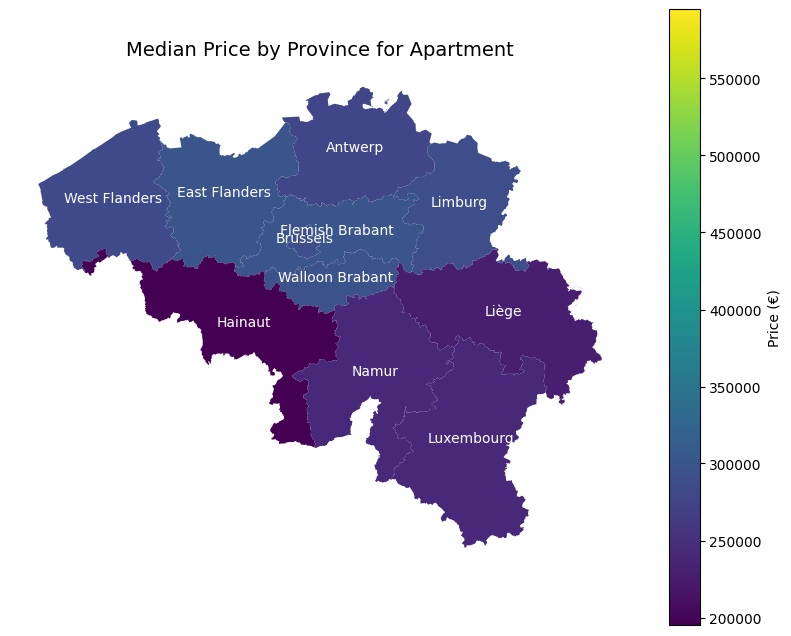

In [31]:
median_apt["ENG_Name"] = median_apt["province"]
merged = gdf.merge(median_apt, on="ENG_Name")

fig, ax = plt.subplots(figsize=(10, 8))

merged.plot(column="price",  cmap="viridis", legend=True,legend_kwds={'label': "Price (€)", 'orientation': "vertical"}, ax=ax, vmin=vmin, vmax=vmax)
merged.apply(lambda x: ax.annotate(text=x.ENG_Name, xy=x.geometry.centroid.coords[0], ha='center', color = "white"), axis=1)
# for idx, row in merged.iterrows():
#     centroid = row['geometry'].centroid
#     ax.text(s=row['ENG_Name'], x=centroid.x, y=centroid.y,
#             horizontalalignment='center', fontsize=9, fontweight='bold', color='white')

ax.set_title("Median Price by Province for Apartment", fontsize=14)
ax.axis("off")
plt.show()

In [ ]:
print(apt_filtered.groupby("province")["price_per_m2"].mean().sort_values(ascending=False))

info = apt_filtered.groupby("province")["price_per_m2"].mean().sort_values(ascending=False)



province
Brussels           3683.191148
West Flanders      3620.309939
Flemish Brabant    3486.840401
Walloon Brabant    3289.704181
East Flanders      3286.345575
Antwerp            3235.271203
Limburg            2977.480323
Luxembourg         2831.505028
Namur              2768.043364
Liège              2518.832888
Hainaut            2171.306083
Name: price_per_m2, dtype: float64


In [182]:
print(houses_filtered.groupby("province")["price_per_m2"].mean().sort_values(ascending=False))

province
Brussels           2842.928642
Walloon Brabant    2516.872727
Flemish Brabant    2489.892567
Antwerp            2367.516943
East Flanders      2186.380176
West Flanders      2050.673640
Limburg            1964.236423
Luxembourg         1851.606162
Namur              1846.686427
Liège              1775.464236
Hainaut            1529.529275
Name: price_per_m2, dtype: float64


In [183]:
print(apt_df.groupby("province")["price_per_m2"].median().sort_values(ascending=False))

province
West Flanders      4071.428571
Brussels           3590.909091
Flemish Brabant    3531.447785
East Flanders      3274.336283
Walloon Brabant    3205.824972
Antwerp            3181.818182
Limburg            2971.014493
Namur              2832.132023
Luxembourg         2818.181818
Liège              2482.407407
Hainaut            2133.333333
Name: price_per_m2, dtype: float64


In [184]:
print(houses_df.groupby("province")["price_per_m2"].median().sort_values(ascending=False))

province
Brussels           3055.555556
Walloon Brabant    2509.090909
Flemish Brabant    2507.246377
Antwerp            2349.794239
East Flanders      2153.110048
West Flanders      2090.148275
Limburg            1936.585366
Namur              1851.484788
Luxembourg         1799.532710
Liège              1705.680902
Hainaut            1442.307692
Name: price_per_m2, dtype: float64


In [29]:
print(houses_df.groupby("province")["price"].median().sort_values(ascending=False))

province
Brussels           780000.0
Flemish Brabant    494000.0
Walloon Brabant    475000.0
Antwerp            449000.0
East Flanders      385000.0
West Flanders      375000.0
Limburg            369000.0
Luxembourg         325000.0
Namur              320000.0
Liège              280000.0
Hainaut            250000.0
Name: price, dtype: float64


In [30]:
print(apt_df.groupby("province")["price"].median().sort_values(ascending=False))

province
West Flanders      335000.0
Brussels           315000.0
East Flanders      300000.0
Flemish Brabant    299675.0
Walloon Brabant    299000.0
Limburg            294000.0
Antwerp            288000.0
Namur              242277.5
Luxembourg         240000.0
Liège              229750.0
Hainaut            195000.0
Name: price, dtype: float64


locality_clean
Knokke-Heist     5747.437836
Waasmunster      5739.910314
Elsene           5080.645161
Heist-aan-Zee    5068.824405
BRUSSEL          4952.380952
Sint-Idesbald    4822.580645
LEUVEN           4821.428571
Nieuwpoort       4817.424242
Duinbergen       4750.000000
Oostduinkerke    4647.887324
Name: price_per_m2, dtype: float64
<class 'pandas.core.series.Series'>


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/1984117094.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_apt.values, y=top10_apt.index, palette="viridis")


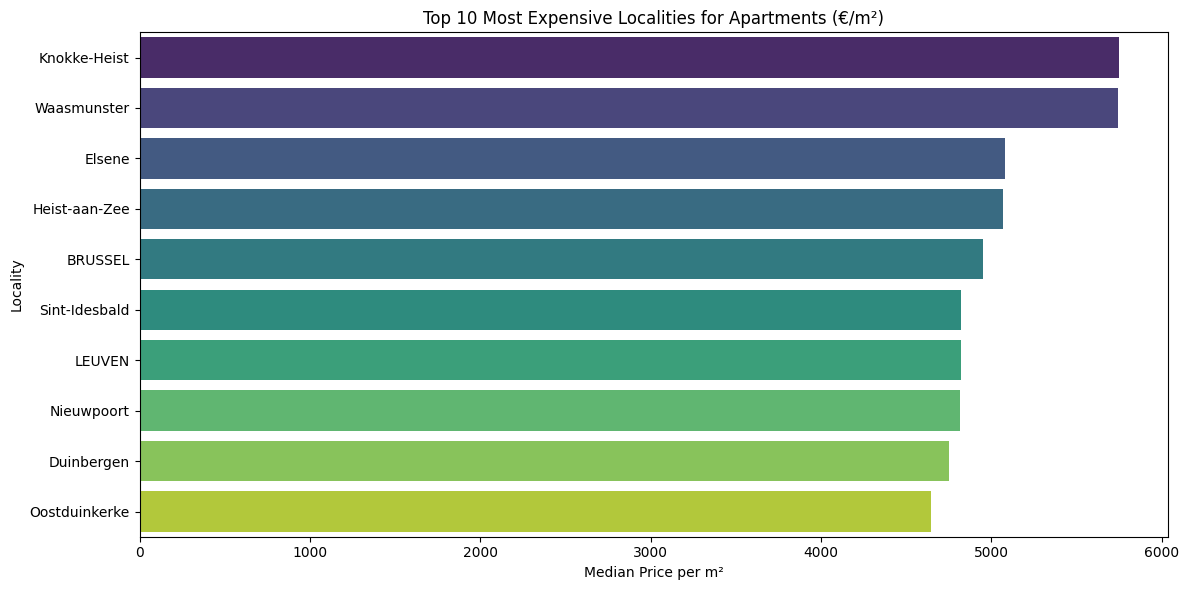

In [185]:
apt_df = df_cleaned[df_cleaned['type'] == 'APARTMENT']

Q1 = apt_df['price_per_m2'].quantile(0.25)
Q3 = apt_df['price_per_m2'].quantile(0.75)
IQR = Q3 - Q1

filtered_apt_df = apt_df[
    (apt_df['price_per_m2'] >= Q1 - 1.5 * IQR) & 
    (apt_df['price_per_m2'] <= Q3 + 1.5 * IQR)
].copy()  

locality_mapping = {
    'KNOKKE': 'Knokke-Heist',
    'KNOKKE-HEIST': 'Knokke-Heist',
    'KNOKKE-HEIST-KNOKKE': 'Knokke-Heist',
    'KNOKKE-ALBERTPLAGE': 'Knokke-Heist',
    'ALBERTPLAGE': 'Knokke-Heist',
    'het Zoute': 'Het Zoute',
    'ZOUTE': 'Het Zoute',
    'HET-ZOUTE': 'Het Zoute',
    'KNOKKE-ZOUTE': 'Het Zoute',
    'KNOKKE- ZOUTE': 'Het Zoute',
    'KNOKKE-HET-ZOUTE': 'Het Zoute',
    'Knokke-Zoute': 'Het Zoute',
    "Knokke": 'Knokke-Heist',
    'Leuven': "LEUVEN",
    'NIEUWPOORT': "Nieuwpoort",
    'CHARLEROI': 'Charleroi',
    'MOUSCRON' : 'Mouscron'
}

filtered_apt_df['locality_clean'] = filtered_apt_df['locality'].replace(locality_mapping)

counts = filtered_apt_df.groupby('locality_clean').size()
valid_localities = counts[counts >= 10].index
final_filtered_apt_df = filtered_apt_df[filtered_apt_df['locality_clean'].isin(valid_localities)]

median_prices = final_filtered_apt_df.groupby('locality_clean')['price_per_m2'].median().sort_values(ascending=False)

top10_apt= median_prices.head(10)
print(top10_apt)
print(type(top10_apt)) 
top10_apt_dict = top10_apt.to_dict()

plt.figure(figsize=(12, 6))
sns.barplot(x=top10_apt.values, y=top10_apt.index, palette="viridis")
plt.title("Top 10 Most Expensive Localities for Apartments (€/m²)")
plt.xlabel("Median Price per m²")
plt.ylabel("Locality")
plt.tight_layout()
plt.show()


locality_clean
Marcinelle       1250.000000
Dottignies       1321.408046
Charleroi        1566.964286
La Louvière      1600.000000
Chaudfontaine    1772.531328
ROESELARE        1807.692308
Oostrozebeke     1847.315187
HERSTAL          1855.003292
Mouscron         1904.347826
Verviers         1930.006930
Name: price_per_m2, dtype: float64


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/564114014.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_10_apt.values, y=bottom_10_apt.index, palette="viridis")


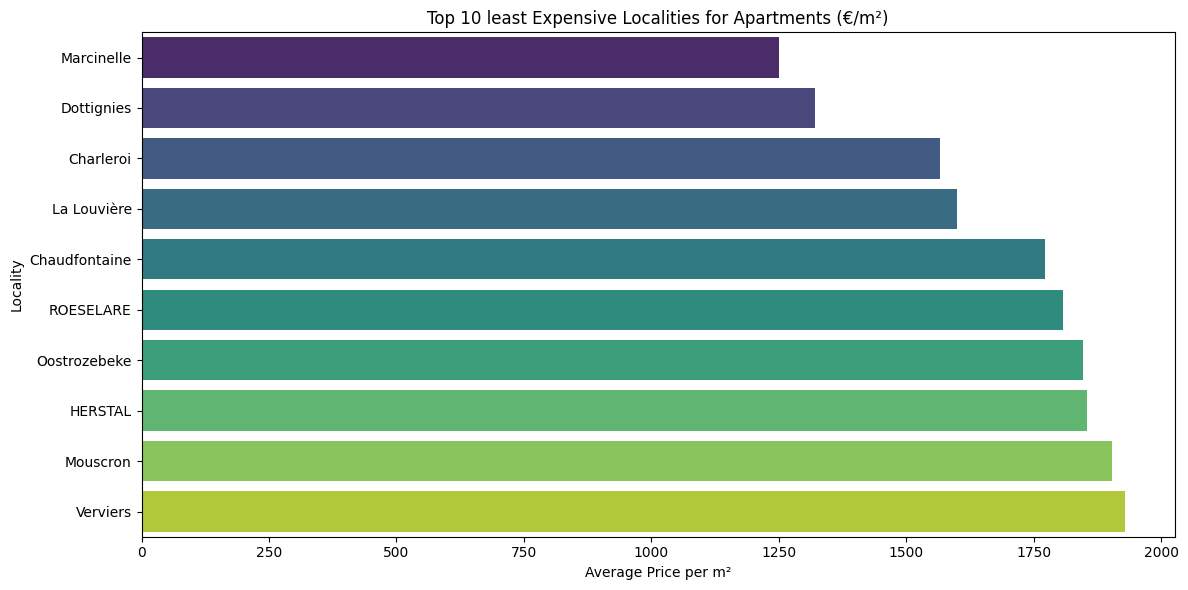

In [186]:
bottom_10_apt = median_prices.nsmallest(10)
print(bottom_10_apt)
bottom_10_apt_dict = bottom_10_apt.to_dict()
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_10_apt.values, y=bottom_10_apt.index, palette="viridis")

plt.title("Top 10 least Expensive Localities for Apartments (€/m²)")
plt.xlabel("Average Price per m²")
plt.ylabel("Locality")
plt.tight_layout()
plt.show()

locality_clean
Knokke-Heist           3756.188119
Watermael-Boitsfort    3568.181818
Wezembeek-Oppem        3553.030303
Lasne                  3449.275362
Ixelles                3440.860215
Woluwe-Saint-Pierre    3405.882353
CHAUMONT-GISTOUX       3314.252490
Uccle                  3310.714286
Rhode-Saint-Genèse     3272.270115
Kraainem               3263.371038
Name: price_per_m2, dtype: float64
<class 'pandas.core.series.Series'>


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/3353816316.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_house.values, y=top10_house.index, palette="viridis")


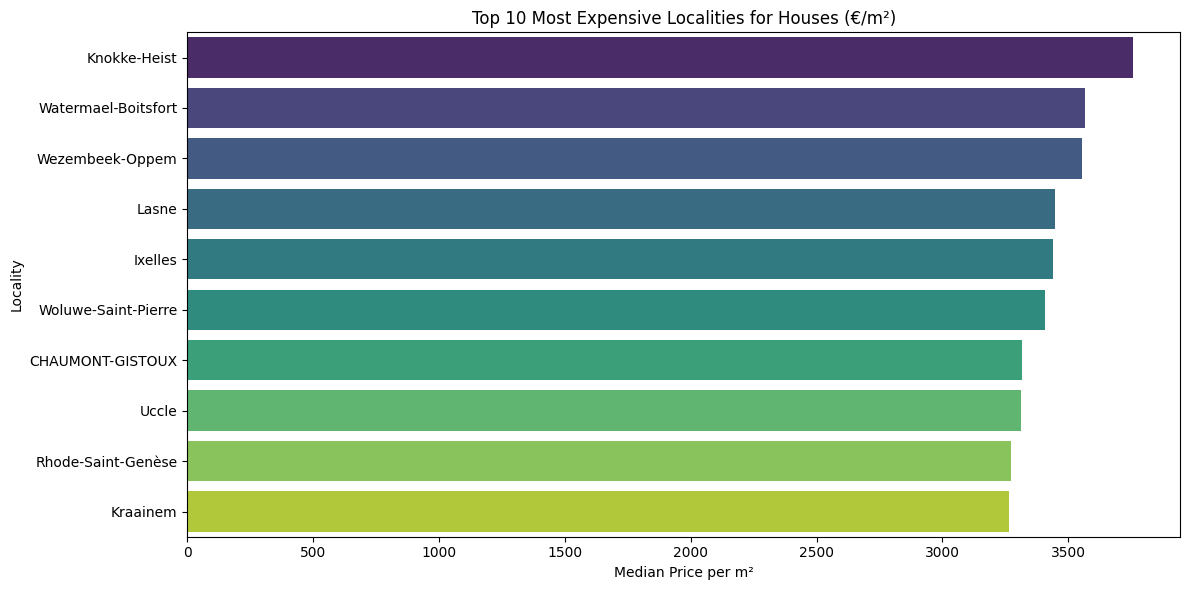

In [187]:

house_df = df_cleaned[df_cleaned['type'] == 'HOUSE']
Q1 = house_df['price_per_m2'].quantile(0.25)
Q3 = house_df['price_per_m2'].quantile(0.75)

IQR = Q3 - Q1

filtered_house_df = house_df[
    (house_df['price_per_m2'] >= Q1 - 1.5 * IQR) & 
    (house_df['price_per_m2'] <= Q3 + 1.5 * IQR)
].copy()  


locality_mapping = {
    'KNOKKE': 'Knokke-Heist',
    'KNOKKE-HEIST': 'Knokke-Heist',
    'KNOKKE-HEIST-KNOKKE': 'Knokke-Heist',
    'KNOKKE-ALBERTPLAGE': 'Knokke-Heist',
    'ALBERTPLAGE': 'Knokke-Heist',
    'het Zoute': 'Het Zoute',
    'ZOUTE': 'Het Zoute',
    'HET-ZOUTE': 'Het Zoute',
    'KNOKKE-ZOUTE': 'Het Zoute',
    'KNOKKE- ZOUTE': 'Het Zoute',
    'KNOKKE-HET-ZOUTE': 'Het Zoute',
    'Knokke-Zoute': 'Het Zoute',
    "Knokke": 'Knokke-Heist',
    'Leuven': "LEUVEN",
    'NIEUWPOORT': "Nieuwpoort",
    'CHARLEROI': 'Charleroi',
    'MOUSCRON' : 'Mouscron'
}

filtered_house_df['locality_clean'] = filtered_house_df['locality'].replace(locality_mapping)
counts = filtered_house_df.groupby('locality_clean').size()
valid_localities = counts[counts >= 10].index
final_filtered_house_df = filtered_house_df[filtered_house_df['locality_clean'].isin(valid_localities)]

median_prices = final_filtered_house_df.groupby('locality_clean')['price_per_m2'].median().sort_values(ascending=False)

top10_house = median_prices.head(10)
print(top10_house)
print(type(top10_house))
top10_house_dict = top10_house.to_dict()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_house.values, y=top10_house.index, palette="viridis")

plt.title("Top 10 Most Expensive Localities for Houses (€/m²)")
plt.xlabel("Median Price per m²")
plt.ylabel("Locality")
plt.tight_layout()
plt.show()

locality_clean
Quiévrain              840.626765
MARCHIENNE-AU-PONT     857.133333
FORCHIES-LA-MARCHE     922.698450
Boussu                 962.732919
Bertrix                977.613636
MONCEAU-SUR-SAMBRE     979.448630
Charleroi Roux        1000.000000
Alveringem            1001.685248
QUAREGNON             1007.462687
FRAMERIES             1036.472567
Name: price_per_m2, dtype: float64


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/4114503864.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_10_house.values, y=bottom_10_house.index, palette="viridis")


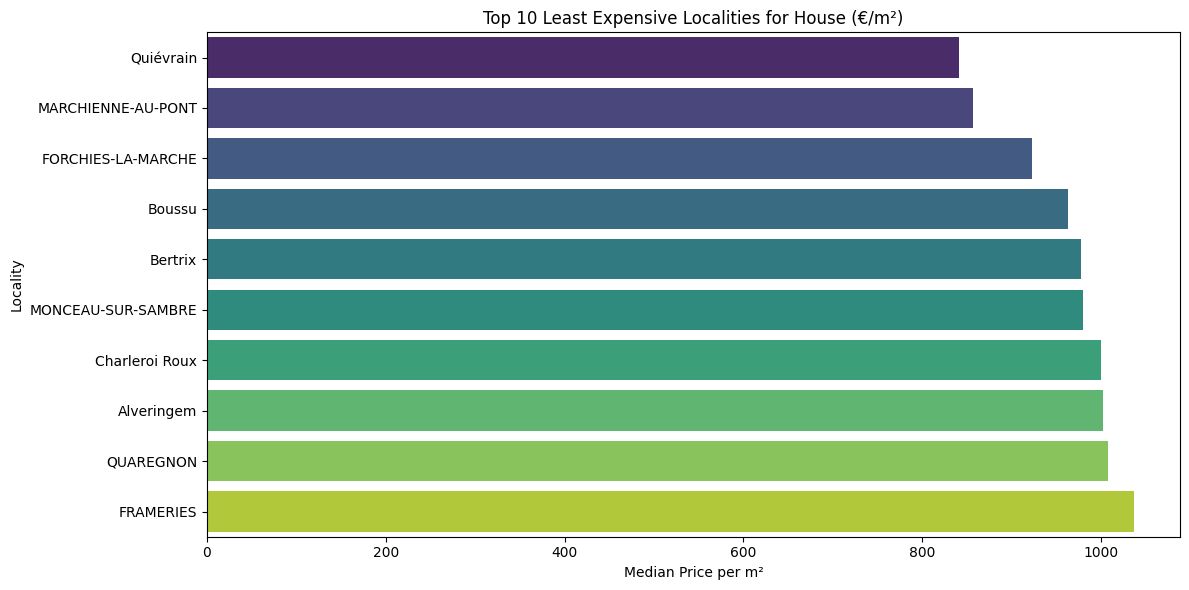

In [188]:
bottom_10_house = median_prices.nsmallest(10)
print(bottom_10_house)
bottom_10_house_dict = bottom_10_house.to_dict()

plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_10_house.values, y=bottom_10_house.index, palette="viridis")
plt.title("Top 10 Least Expensive Localities for House (€/m²)")
plt.xlabel("Median Price per m²")
plt.ylabel("Locality")
# plt.xlim(x_min, x_max)
plt.tight_layout()
plt.show()

<class 'dict'>
<class 'dict'>


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/1577577518.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apt_prices, y=apt_localities, palette="viridis", ax=axes[0])
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/1577577518.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=house_prices, y=house_localities, palette="magma", ax=axes[1])


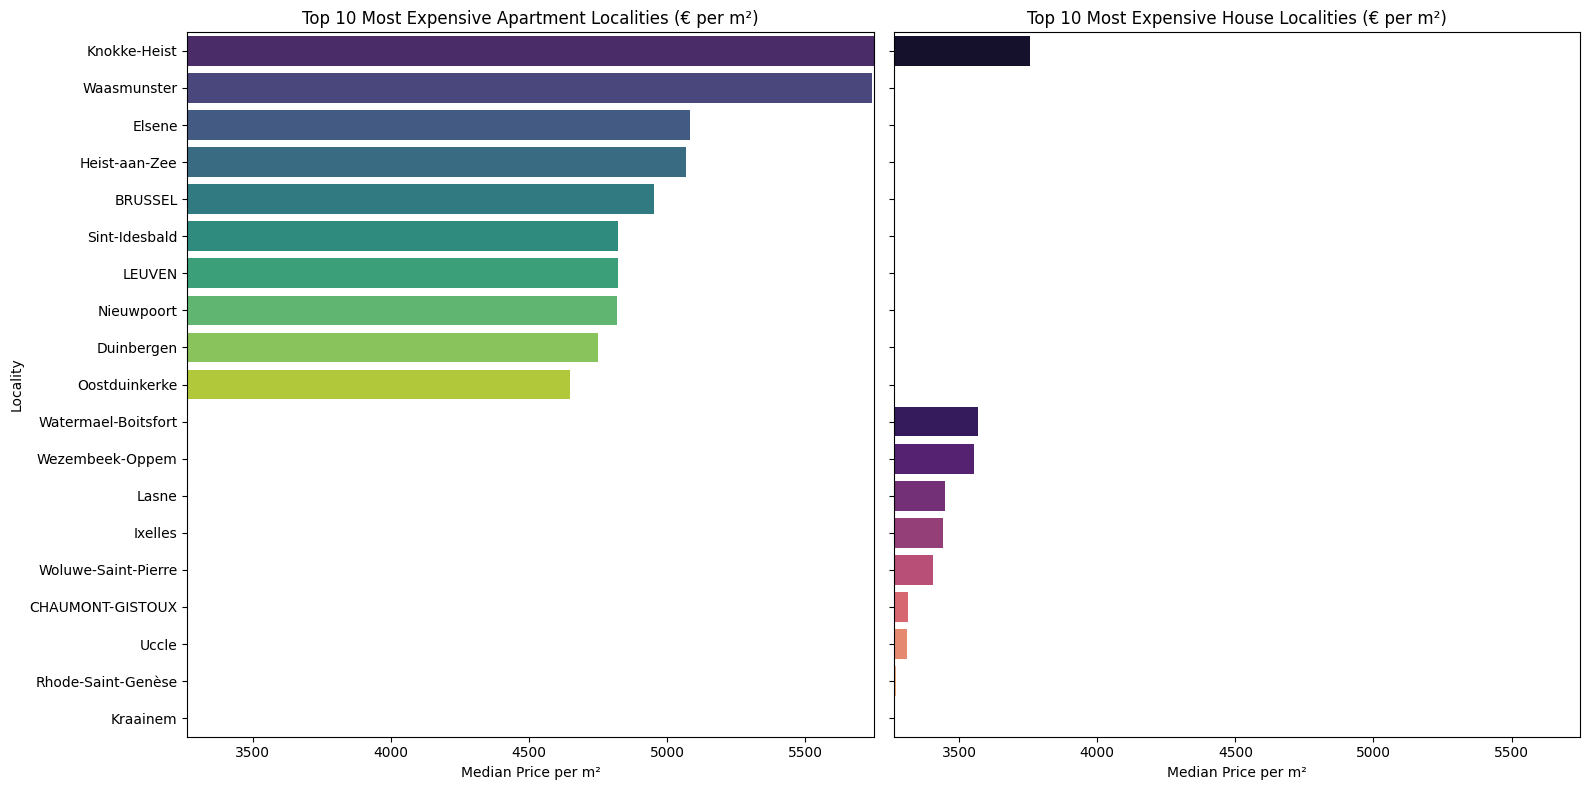

In [189]:

print(type(top10_apt_dict))
print(type(top10_house_dict))


apt_localities = list(top10_apt_dict.keys())
apt_prices = list(top10_apt_dict.values())
house_localities = list(top10_house_dict.keys())
house_prices = list(top10_house_dict.values())
xmin = min(min(apt_prices), min(house_prices))
xmax = max(max(apt_prices), max(house_prices))
fig, axes = plt.subplots(1,2, figsize=(16, 8), sharey=True)

# Apartments plot
sns.barplot(x=apt_prices, y=apt_localities, palette="viridis", ax=axes[0])
axes[0].set_title("Top 10 Most Expensive Apartment Localities (€ per m²)")
axes[0].set_xlabel("Median Price per m²")
axes[0].set_ylabel("Locality")
axes[0].set_xlim(xmin, xmax)

# Houses plot
sns.barplot(x=house_prices, y=house_localities, palette="magma", ax=axes[1])
axes[1].set_title("Top 10 Most Expensive House Localities (€ per m²)")
axes[1].set_xlabel("Median Price per m²")
axes[1].set_ylabel("")
axes[1].set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/2270350271.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apt_prices, y=apt_localities, palette="viridis", ax=axes[0])
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_25816/2270350271.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=house_prices, y=house_localities, palette="magma", ax=axes[1])


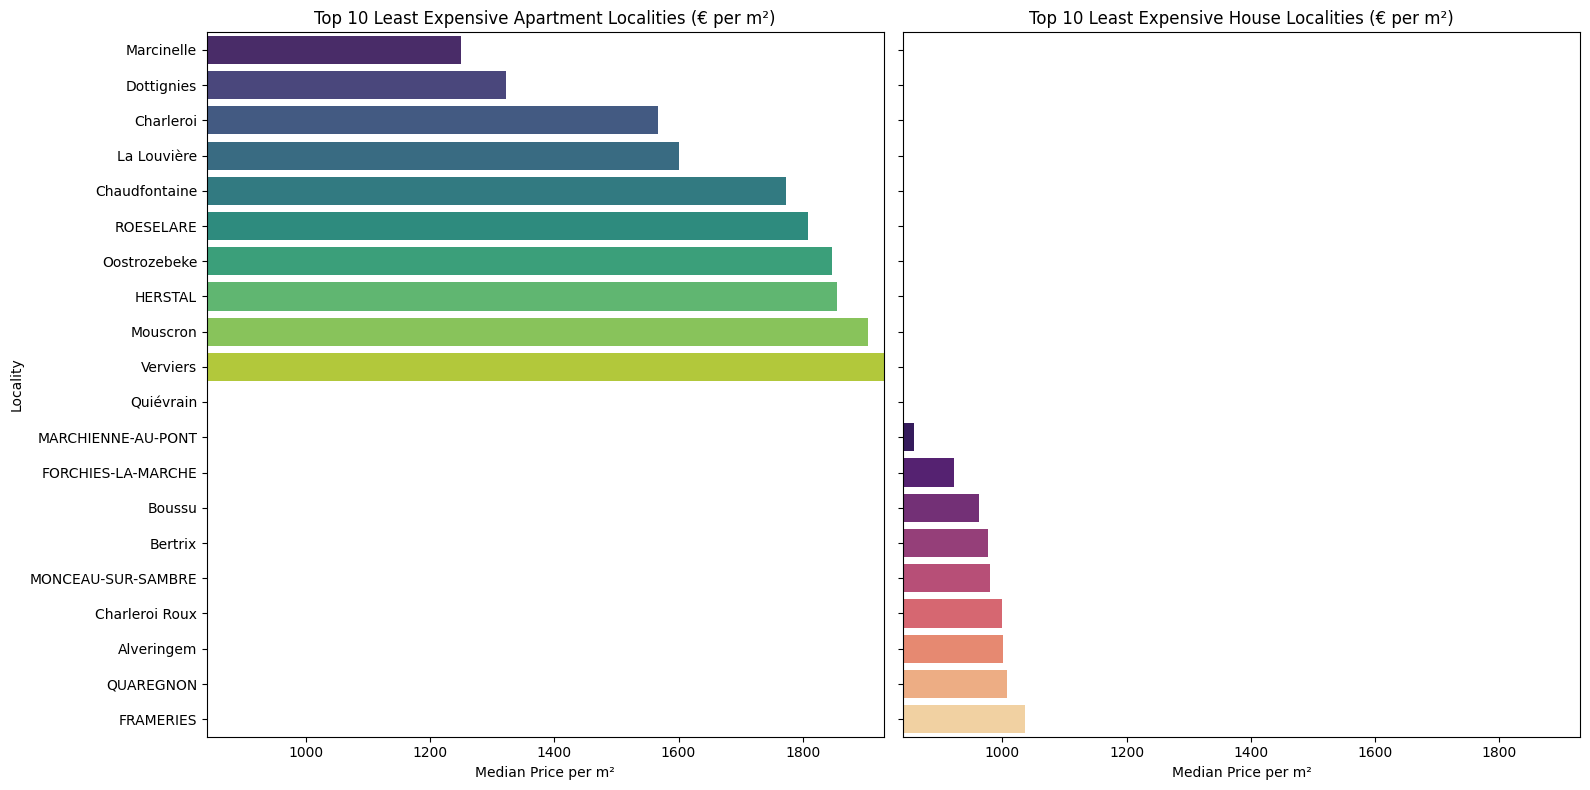

In [190]:


apt_localities = list(bottom_10_apt_dict.keys())
apt_prices = list(bottom_10_apt_dict.values())
house_localities = list(bottom_10_house_dict.keys())
house_prices = list(bottom_10_house_dict.values())

xmin = min(min(apt_prices), min(house_prices))
xmax = max(max(apt_prices), max(house_prices))

fig, axes = plt.subplots(1,2, figsize=(16, 8), sharey=True)

# Apartments plot
sns.barplot(x=apt_prices, y=apt_localities, palette="viridis", ax=axes[0])
axes[0].set_title("Top 10 Least Expensive Apartment Localities (€ per m²)")
axes[0].set_xlabel("Median Price per m²")
axes[0].set_ylabel("Locality")
axes[0].set_xlim(xmin, xmax)

# Houses plot
sns.barplot(x=house_prices, y=house_localities, palette="magma", ax=axes[1])
axes[1].set_title("Top 10 Least Expensive House Localities (€ per m²)")
axes[1].set_xlabel("Median Price per m²")
axes[1].set_ylabel("")  
axes[1].set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()

In [ ]:
region_median_prices_apt = final_filtered_apt_df.groupby(['region', 'mini'])['price_per_m2'].median().reset_index()
top_by_region_apt = region_median_prices_apt.sort_values(['region', 'price_per_m2'], ascending=[True, False])
top5_each_region_apt = top_by_region_apt.groupby('region').head(5)

print(top5_each_region_apt)

       region              locality_clean  price_per_m2
14   Brussels                      Elsene   5080.645161
5    Brussels                     BRUSSEL   4952.380952
22   Brussels                     Ixelles   4602.631579
3    Brussels                   Auderghem   4535.151015
43   Brussels                       Ukkel   4357.142857
179  Flanders                Knokke-Heist   5747.437836
302  Flanders                 Waasmunster   5739.910314
155  Flanders               Heist-aan-Zee   5068.824405
268  Flanders               Sint-Idesbald   4822.580645
188  Flanders                      LEUVEN   4821.428571
372  Wallonia                       Liege   4560.000000
386  Wallonia  Ottignies-Louvain-la-Neuve   4433.333333
345  Wallonia            Chaumont-Gistoux   4218.750000
401  Wallonia                    VIELSALM   3893.442623
391  Wallonia                   Rixensart   3870.842572


In [197]:
bottom_by_region_apt = region_median_prices_apt.sort_values(['region', 'price_per_m2'], ascending=[True, True])
bottom5_each_region_apt = bottom_by_region_apt.groupby('region').head(5)
print(bottom5_each_region_apt)

       region        locality_clean  price_per_m2
29   Brussels  Molenbeek-Saint-Jean   2557.142857
27   Brussels                Laeken   2597.826087
26   Brussels            Koekelberg   2634.505022
20   Brussels             Ganshoren   2711.960851
33   Brussels   SINT-JANS-MOLENBEEK   2715.189873
246  Flanders             ROESELARE   1807.692308
237  Flanders          Oostrozebeke   1847.315187
220  Flanders                 Menen   1951.693577
143  Flanders              Gullegem   2089.957265
119  Flanders        Dilsen-Stokkem   2132.478632
377  Wallonia            Marcinelle   1250.000000
349  Wallonia            Dottignies   1321.408046
343  Wallonia             Charleroi   1566.964286
370  Wallonia           La Louvière   1600.000000
344  Wallonia         Chaudfontaine   1772.531328


In [193]:
region_median_prices_house = final_filtered_house_df.groupby(['region', 'locality_clean'])['price_per_m2'].median().reset_index()
top_by_region_house = region_median_prices_house.sort_values(['region', 'price_per_m2'], ascending=[True, False])
top5_each_region_house = top_by_region_house.groupby('region').head(5)

print(top5_each_region_house)

       region       locality_clean  price_per_m2
19   Brussels  Watermael-Boitsfort   3568.181818
10   Brussels              Ixelles   3440.860215
21   Brussels  Woluwe-Saint-Pierre   3405.882353
18   Brussels                Uccle   3310.714286
6    Brussels            Etterbeek   3187.386260
221  Flanders         Knokke-Heist   3756.188119
419  Flanders      Wezembeek-Oppem   3553.030303
340  Flanders   Rhode-Saint-Genèse   3272.270115
230  Flanders             Kraainem   3263.371038
375  Flanders   Sint-Martens-Latem   3236.301370
589  Wallonia                Lasne   3449.275362
487  Wallonia     CHAUMONT-GISTOUX   3314.252490
655  Wallonia              Rocourt   3121.635135
649  Wallonia            RIXENSART   3071.352268
547  Wallonia               Genval   3066.666667


In [198]:
bottom_by_region_house = region_median_prices_apt.sort_values(['region', 'price_per_m2'], ascending=[True, True])
bottom5_each_region_house = bottom_by_region_house.groupby('region').head(5)
print(bottom5_each_region_house)

       region        locality_clean  price_per_m2
29   Brussels  Molenbeek-Saint-Jean   2557.142857
27   Brussels                Laeken   2597.826087
26   Brussels            Koekelberg   2634.505022
20   Brussels             Ganshoren   2711.960851
33   Brussels   SINT-JANS-MOLENBEEK   2715.189873
246  Flanders             ROESELARE   1807.692308
237  Flanders          Oostrozebeke   1847.315187
220  Flanders                 Menen   1951.693577
143  Flanders              Gullegem   2089.957265
119  Flanders        Dilsen-Stokkem   2132.478632
377  Wallonia            Marcinelle   1250.000000
349  Wallonia            Dottignies   1321.408046
343  Wallonia             Charleroi   1566.964286
370  Wallonia           La Louvière   1600.000000
344  Wallonia         Chaudfontaine   1772.531328
